In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import math
from IPython.display import display, Markdown

# Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocesssing
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from scipy.stats import norm
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.pipeline import Pipeline

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.model_selection import GridSearchCV

# Evaludation
from sklearn.model_selection import cross_val_score, ShuffleSplit, learning_curve, cross_val_predict, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, average_precision_score
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve, confusion_matrix
from imblearn.metrics import classification_report_imbalanced

import warnings
warnings.filterwarnings('ignore')

In [2]:
CV_EVALUATION = True

# Load Data

In [3]:
df = pd.read_csv("creditcard.csv")
df.shape

(284807, 31)

# Data Processing

### Scaling

In [4]:
scaler = RobustScaler()

scaled_amount = scaler.fit_transform(df[["Amount"]])
scaled_time = scaler.fit_transform(df[["Time"]])

df.drop(["Amount", "Time"], axis = 1, inplace = True)

df.insert(0, 'scaled_time', scaled_time)
df.insert(1, 'scaled_amount', scaled_amount)

### Remove Outliers

In [5]:
# Calculate Lower and upper bound
features = ["V14", "V12", "V10"]

for i, feature in enumerate(features):
    fraud = df[feature].loc[df["Class"] == 1]
    q25, q75 = np.percentile(fraud, 25), np.percentile(fraud, 75)
    iqr = q75 - q25
    print(f"Q1: {q25: .2f}, Q3: {q75: .2f}, IQR: {iqr: .2f}")
    
    threshhold = iqr * 1.5
    lower, upper = q25 - threshhold, q75 + threshhold
    print(f"{feature} Lower Bound: {lower: .2f}, {feature} Upper Bound: {upper: .2f}")

    outliers = fraud[(fraud < lower) | (fraud > upper)]
    mask = ((df["Class"] == 1) & (df[feature] >= lower) & (df[feature] <= upper))
    df = df[mask | (df["Class"] == 0)]
    print(f"{feature} Outliers Count: {len(outliers)}")
    print("-" * 100)

Q1: -9.69, Q3: -4.28, IQR:  5.41
V14 Lower Bound: -17.81, V14 Upper Bound:  3.83
V14 Outliers Count: 4
----------------------------------------------------------------------------------------------------
Q1: -8.67, Q3: -2.89, IQR:  5.78
V12 Lower Bound: -17.34, V12 Upper Bound:  5.78
V12 Outliers Count: 4
----------------------------------------------------------------------------------------------------
Q1: -7.47, Q3: -2.51, IQR:  4.95
V10 Lower Bound: -14.90, V10 Upper Bound:  4.92
V10 Outliers Count: 27
----------------------------------------------------------------------------------------------------


# Modelling

In [6]:
mini_fraud_X = df[df["Class"] == 1]
mini_non_fraud_X = df[df["Class"] == 0]
mini_non_fraud_X = mini_non_fraud_X.sample(n = int(mini_non_fraud_X.shape[0]/10))
mini_df = pd.concat([mini_fraud_X, mini_non_fraud_X], axis = 0)

mini_X = mini_df.drop("Class", axis = 1)
mini_y = mini_df["Class"]
mini_X_train, mini_X_test, mini_y_train, mini_y_test = train_test_split(mini_X, mini_y, test_size = 0.3, stratify=mini_y, random_state = 42)

X = df.drop("Class", axis = 1)
y = df["Class"]
original_X_train, original_X_test, original_y_train, original_y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state = 42)

train_df = pd.concat([original_X_train, original_y_train], axis = 1)
print(f"Train Dataset Size: {train_df.shape}")

mini_train_df = pd.concat([mini_X_train, mini_y_train], axis = 1)
print(f"Mini Train Dataset Size: {mini_train_df.shape}")

Train Dataset Size: (199340, 31)
Mini Train Dataset Size: (20221, 31)


### Random UnderSampling (Not Suitable because too less fraud - will waste many data)

In [7]:
train_df = train_df.sample(frac=1, random_state = 42)
fraud_df = train_df[train_df["Class"] == 1]
non_fraud_df = train_df[train_df["Class"] == 0].sample(n = fraud_df.shape[0], random_state = 42)
print(f"Fraud Train Dataset Size: {fraud_df.shape}")

undersample_df = pd.concat([fraud_df, non_fraud_df])
undersample_df = undersample_df.sample(frac = 1, random_state = 42)
print(f"Random UnderSampling Train Dataset Size: {undersample_df.shape}")

Fraud Train Dataset Size: (320, 31)
Random UnderSampling Train Dataset Size: (640, 31)


### SMOTE OverSampling

In [8]:
smote = SMOTE(sampling_strategy='minority')
oversample_X_train, oversample_y_train = smote.fit_resample(original_X_train, original_y_train)
print(f"SMOTE OverSampling Train Dataset Size: {oversample_X_train.shape}")

SMOTE OverSampling Train Dataset Size: (398040, 30)


**Models**

In [9]:
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    # "Support Vector Classifier": SVC(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

scoring = {
    "accuracy": make_scorer(accuracy_score),
    "precision": make_scorer(precision_score, average='binary', zero_division=0),
    "recall": make_scorer(recall_score, average='binary'),
    "f1": make_scorer(f1_score, average='binary')
}

In [10]:
for key, initial_model in classifiers.items():

    print('---' * 45)
    
    new_model_path = f"models/{key.replace(" ", "_")}.pkl"
    leakage_model_path = f"leakage_models/{key.replace(" ", "_")}.pkl"
    if os.path.exists(new_model_path):
        print(f"Load trained model for {key}")
        with open(new_model_path, "rb") as f:
            classifiers[key] = pickle.load(f)

        params = classifiers[key].get_params()
        if "n_jobs" in params:
            params['n_jobs'] = -1
            
        model_to_evaluate = type(initial_model)(**params)

    elif os.path.exists(leakage_model_path):
        print(f"Load leakage model for {key}")
        with open(leakage_model_path, "rb") as f:
            leakage_model = pickle.load(f)

        params = leakage_model.get_params()
        if "n_jobs" in params:
            params['n_jobs'] = -1
        
        model_to_evaluate = type(initial_model)(**params)

        print(f"Leakage model parameter for {key}")
        print(f"{leakage_model.get_params()}")

        training_pipeline = Pipeline([
            ("smote", SMOTE(sampling_strategy='minority')),
            ("classifier", model_to_evaluate)
        ])

        training_pipeline.fit(original_X_train, original_y_train)
        classifiers[key] = training_pipeline.named_steps['classifier']
        
        new_model_path = f"models/{key.replace(" ", "_")}.pkl"
        with open(new_model_path, "wb") as f:
                pickle.dump(classifiers[key], f)
  
    else:
        classifiers[key] = None
        print(f"{key}: No Such Model")
        continue

    if CV_EVALUATION:
        cv = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 42)
        pipeline = Pipeline([
            ("smote", SMOTE(sampling_strategy='minority')),
            ("classifier", model_to_evaluate)
        ])
        
        print(f"Evaluate CV for {key}")
        
        if "n_jobs" in params:
            results = cross_validate(pipeline, mini_X_train, mini_y_train, cv = cv, scoring = scoring, return_train_score = True)
        else:
            results = cross_validate(pipeline, mini_X_train, mini_y_train, cv = cv, scoring = scoring, n_jobs = -1, return_train_score = True)
            
        for score_name in scoring.keys():
            print(f"{score_name.capitalize()} (mean): {results[f'test_{score_name}'].mean():.4f}")
        
    print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Load trained model for Logistic Regression
Evaluate CV for Logistic Regression
Accuracy (mean): 0.9733
Precision (mean): 0.3624
Recall (mean): 0.8782
F1 (mean): 0.5122
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
Load trained model for KNearest
Evaluate CV for KNearest
Accuracy (mean): 0.9887
Precision (mean): 0.6025
Recall (mean): 0.8657
F1 (mean): 0.7091
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
Load t

**Neural Network**

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [12]:
class OversampleNet(nn.Module):
    def __init__(self, n_inputs):
        super(OversampleNet, self).__init__()
        self.fc1 = nn.Linear(n_inputs, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [13]:
n_inputs = original_X_train.shape[1]
model = OversampleNet(n_inputs)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

OversampleNet(
  (fc1): Linear(in_features=30, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


In [15]:
batch_size = 1000
epochs = 20

X_train, X_validation, y_train, y_validation = train_test_split(original_X_train, original_y_train, test_size = 0.2,
                                                                stratify=original_y_train, random_state = 42)
smote = SMOTE(sampling_strategy='minority')
oversample_X_train, oversample_y_train = smote.fit_resample(X_train, y_train)

model_path = f"models/nn_model.pth"
if os.path.exists(model_path):
    print(f"Load trained model for Neural Network")
    with open(model_path, "rb") as f:
        model.load_state_dict(torch.load(f))
        model.to(device)
else:
    model.to(device)
    for epoch in range(epochs):
        
        model.train()
        permutation = torch.randperm(len(oversample_X_train))
    
        for i in range(0, oversample_X_train.size, batch_size):
            indices = permutation[i : i + batch_size]
            batch_X, batch_y = oversample_X_train.iloc[indices], oversample_y_train.iloc[indices]
    
            batch_X_tensor = torch.tensor(batch_X.values, dtype=torch.float32).to(device)
            batch_y_tensor = torch.tensor(batch_y.values, dtype=torch.long).to(device)
    
            optimizer.zero_grad()
            outputs = model(batch_X_tensor)
            loss = criterion(outputs, batch_y_tensor)
            loss.backward()
            optimizer.step()
    
        model.eval()
        with torch.no_grad():
    
            val_X_tensor = torch.tensor(X_validation.values, dtype=torch.float32).to(device)
            val_y_tensor = torch.tensor(y_validation.values, dtype=torch.long).to(device)
    
            val_outputs = model(val_X_tensor)
            val_loss = criterion(val_outputs, val_y_tensor)
            val_preds = torch.argmax(val_outputs, dim=1)
            accuracy = (val_preds == val_y_tensor).float().mean()
    
            y_true, y_pred = val_y_tensor.cpu().numpy(), val_preds.cpu().numpy()
            f1 = f1_score(y_true, y_pred, average='binary')
            
            print(f"Epoch {epoch+1}/{epochs} - Val Loss: {val_loss.item():.4f} - Val Accuracy: {accuracy.item():.4f} - Val f1: {f1:.4f}")

if not os.path.exists(model_path):
    with open(model_path, "wb") as f:
        torch.save(model.state_dict(), f)

Load trained model for Neural Network


In [17]:
val_X_tensor = torch.tensor(X_validation.values, dtype=torch.float32).to(device)
val_y_tensor = torch.tensor(y_validation.values, dtype=torch.long).to(device)

val_outputs = model(val_X_tensor)
val_preds = torch.argmax(val_outputs, dim=1)
y_true = val_y_tensor.cpu().numpy()
y_pred = val_preds.cpu().numpy()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='binary', zero_division=0)
recall = recall_score(y_true, y_pred, average='binary')
f1 = f1_score(y_true, y_pred, average='binary')

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.9993
Precision: 0.7500
Recall:    0.8438
F1 Score:  0.7941


# Evaluation

## ROC AUC

In [18]:
def plot_roc_curve(predictions, dataset, y_train):
    rocaucs = {}

    for key, prediction in predictions.items():
        fpr, tpr, threshold = roc_curve(y_train, prediction)
        rocaucs[key] = [fpr, tpr, threshold]
    
    plt.figure(figsize=(16, 8))
    plt.title(f"ROC Curve ({dataset} Dataset)", fontsize = 18)

    for key, rocauc in rocaucs.items():
        plt.plot(rocauc[0], rocauc[1], label = f"{key} Score: {roc_auc_score(y_train, predictions[key]): .4f}")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])

    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50%', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                 arrowprops=dict(facecolor='#6E726D', shrink=0.05))
    plt.legend()

In [19]:
predictions = {}
for key, classifier in classifiers.items():
    print(f"Prediction using {key}")
    pred = classifier.predict(original_X_test)
    predictions[key] = pred

test_X_tensor = torch.tensor(original_X_test.values, dtype=torch.float32).to(device)
test_y_tensor = torch.tensor(original_y_test.values, dtype=torch.float32).to(device)

test_outputs = model(test_X_tensor)
pred = torch.argmax(test_outputs, dim=1)
predictions["Neural Network"] = pred.cpu().numpy()

Prediction using Logistic Regression
Prediction using KNearest
Prediction using Decision Tree
Prediction using Random Forest
Prediction using Gradient Boosting Classifier
Prediction using AdaBoost


In [20]:
for key, prediction in predictions.items():
    print(f"{key}: {roc_auc_score(original_y_test, prediction): .4f}")

Logistic Regression:  0.7700
KNearest:  0.8831
Decision Tree:  0.8684
Random Forest:  0.8795
Gradient Boosting Classifier:  0.7137
AdaBoost:  0.8466
Neural Network:  0.9304


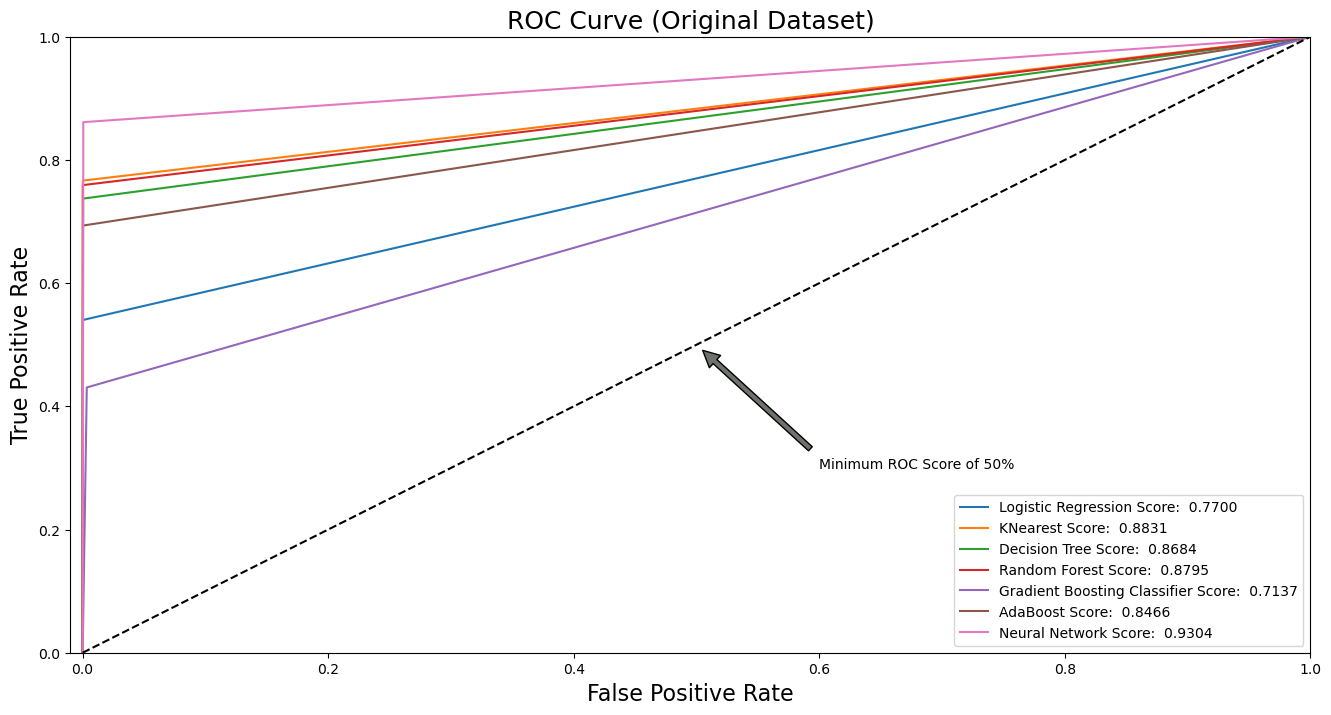

In [21]:
plot_roc_curve(predictions, "Original", original_y_test)
plt.show()

## Precisioin Recall CUrve

In [43]:
def plot_pr_curve(y_scores, average_pr_scores, original_y_test):

    plt.figure(figsize=(16, 8))
    plt.title(f"Precision Recall Curve (Original Dataset)", fontsize = 18)

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    for i, (key, y_score) in enumerate(y_scores.items()):
        precision, recall, _ = precision_recall_curve(original_y_test, y_score)
        plt.step(recall, precision, color=colors[i % len(colors)], alpha=0.2, where='post', label = f"{key} Score: {average_pr_scores[key]:0.2f}")

    plt.xlabel('Recall', fontsize=16)
    plt.ylabel('Precision', fontsize=16)
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.legend()

In [44]:
y_scores = {}
for key, classifier in classifiers.items():
    y_score = classifier.predict_proba(original_X_test)[:, 1]
    y_scores[key] = y_score

average_pr_scores = {}
for key, y_score in y_scores.items():
    average_pr = average_precision_score(original_y_test, y_score)
    average_pr_scores[key] = average_pr

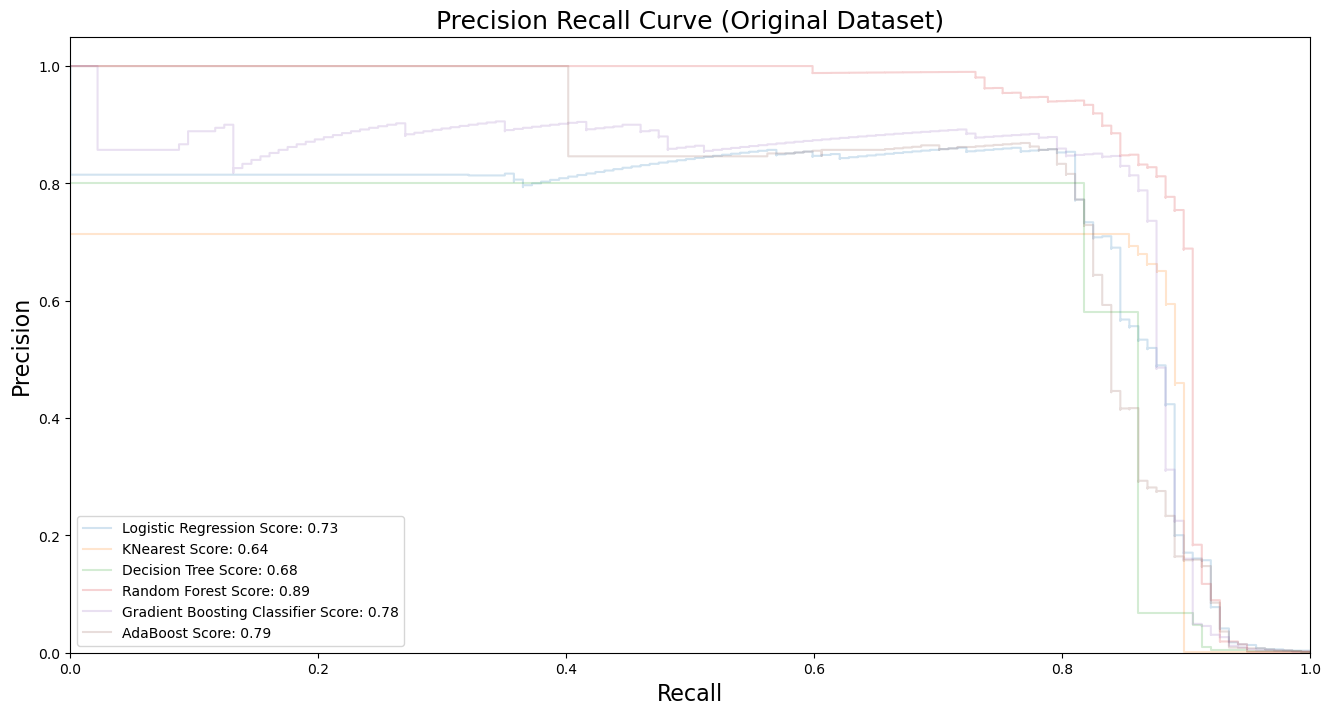

In [45]:
plot_pr_curve(y_scores, average_pr_scores, original_y_test)
plt.show()

## Classification Report

In [24]:
labels = ['No Fraud', 'Fraud']

for key, prediction in predictions.items():
    print("-"*25 + f"{key}" + "-"*25)
    print(classification_report(original_y_test, prediction, target_names=labels))

-------------------------Logistic Regression-------------------------
              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     85295
       Fraud       0.84      0.54      0.66       137

    accuracy                           1.00     85432
   macro avg       0.92      0.77      0.83     85432
weighted avg       1.00      1.00      1.00     85432

-------------------------KNearest-------------------------
              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     85295
       Fraud       0.90      0.77      0.83       137

    accuracy                           1.00     85432
   macro avg       0.95      0.88      0.91     85432
weighted avg       1.00      1.00      1.00     85432

-------------------------Decision Tree-------------------------
              precision    recall  f1-score   support

    No Fraud       1.00      1.00      1.00     85295
       Fraud       0.78      0.74      0.76 

## Confusion Matrix

In [34]:
import itertools
def plot_confusion_matrix(cm, classes, ax, normalise = False, title = "Confusion Matrix", cmap=plt.cm.Blues):
    if normalise:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title, fontsize=8)
    plt.colorbar(im, ax = ax)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(classes, rotation=45)
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(classes)

    fmt = '.2f' if normalise else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 ha="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization


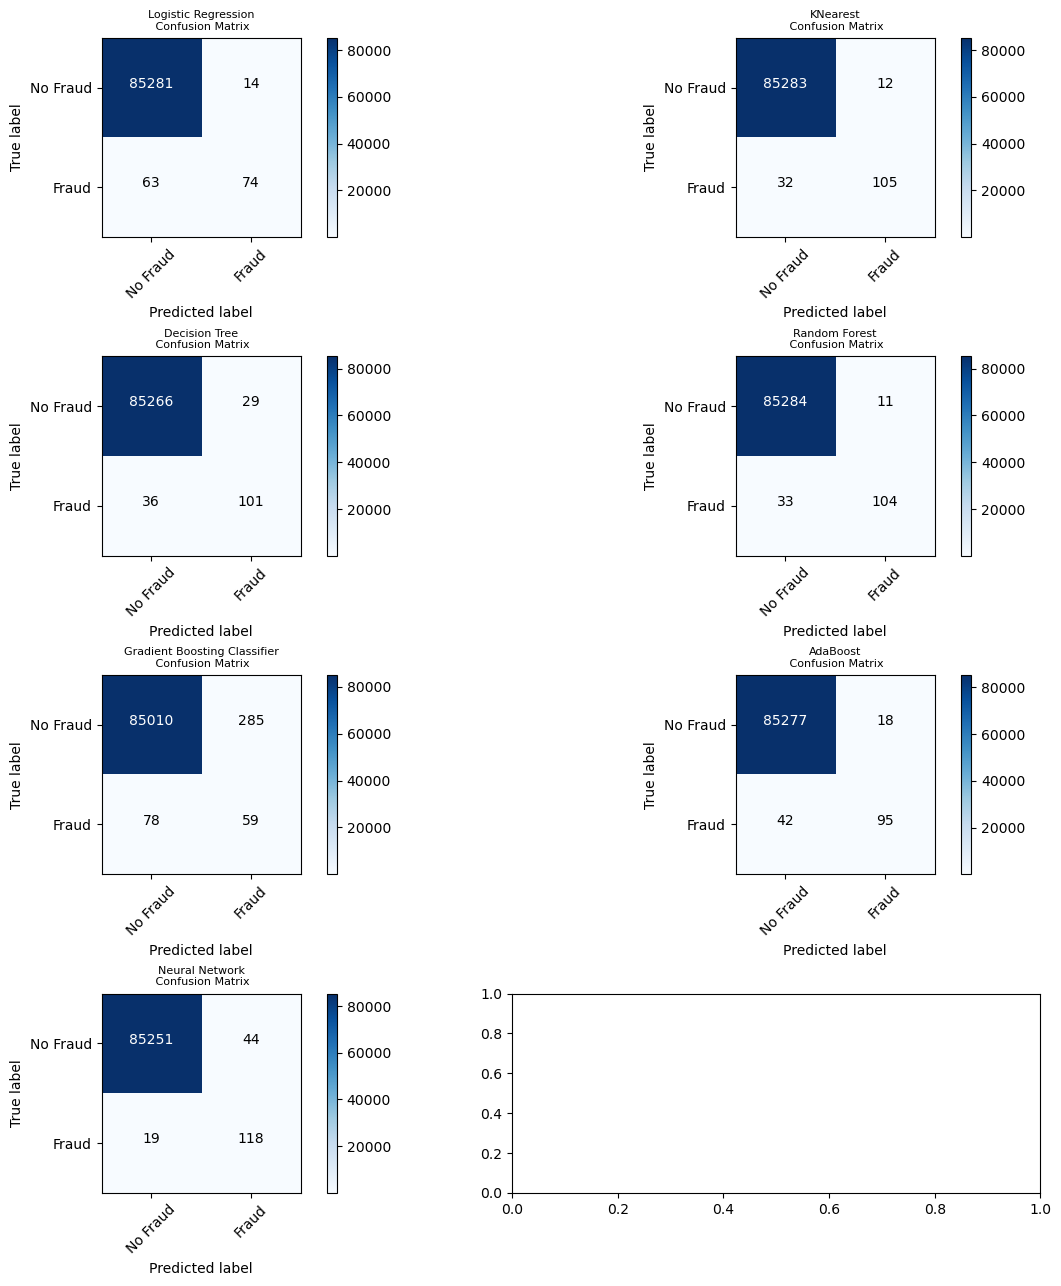

In [35]:
n_models = len(predictions)
n_rows = math.ceil(n_models / 2)
fig, ax = plt.subplots(n_rows, 2,figsize=(15,15))
ax = ax.flatten()
plt.subplots_adjust(hspace=0.6)

labels = ['No Fraud', 'Fraud']
for i, (key, prediction) in enumerate(predictions.items()):
    cm = confusion_matrix(original_y_test, prediction)
    plot_confusion_matrix(cm, labels, title=f"{key}\n Confusion Matrix", ax = ax[i])